In [0]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
link = 'https://drive.google.com/open?id=1YYcPg4eT9CKR1X3DkYoZdokc24oWyakw' # The shareable link
fluff, id = link.split('=')

In [0]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('ASX200Daily.csv')

In [10]:
!pip install -q pmdarima

     |████████████████████████████████| 921kB 2.8MB/s 


In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import statsmodels as sm 
import statsmodels.api as smt
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima

ImportError: ignored

In [0]:
# Reading data
daily_data = pd.read_csv('ASX200Daily.csv')

In [16]:
# Converting to a time series
daily_data['Date'] = pd.to_datetime(daily_data['Date'])
daily_data.set_index('Date', inplace = True)
daily_ts = pd.Series(daily_data['Close'])
print(daily_ts.head())

Date
2000-03-31    3133.300049
2000-04-03    3191.000000
2000-04-04    3176.800049
2000-04-05    3155.399902
2000-04-06    3157.100098
Name: Close, dtype: float64


In [0]:
# Removing missing values
daily_ts.dropna(inplace=True)

In [0]:
# Splitting data into training and validation subsets
training_subset = daily_ts[:-365]
validation_subset = daily_ts[-365:]

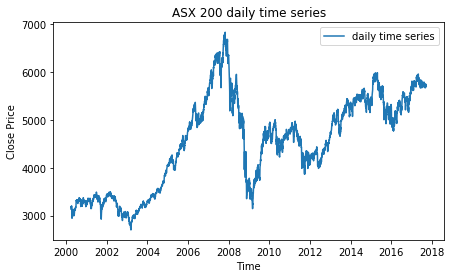

In [26]:
# Setting figure width and height
rcParams['figure.figsize'] = 7, 4

# Plotting time series
plt.plot(training_subset, label = "daily time series")
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('ASX 200 daily time series')
plt.legend()

In [27]:
# ACF plot of the original data
smt.graphics.tsa.plot_acf(training_subset, lags = 30, alpha = 0.05)
plt.show()

# PACF plot of the original data
smt.graphics.tsa.plot_pacf(training_subset, lags = 30, alpha = 0.05)
plt.show()

NameError: ignored

As we can see from the plots above, ACF does not die down quickly which means that the time series is non-stationary. We will apply transformations to the data to make it stationary.

In [0]:
# Transforming time series by taking log
# It reduces variation in data by penalizing larger values more than the smaller ones
training_subset_log = np.log(training_subset)

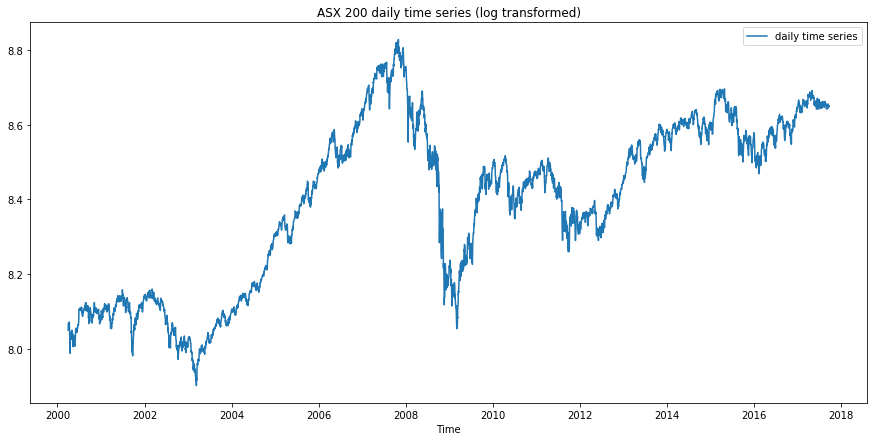

In [0]:
# Plotting log transformed time series
plt.plot(training_subset_log, label = "daily time series")
plt.xlabel('Time')
plt.title('ASX 200 daily time series (log transformed)')
plt.legend()

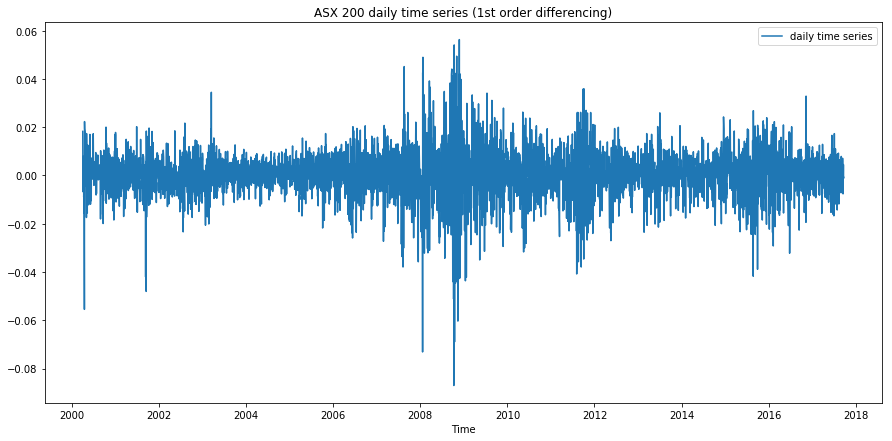

In [0]:
# Applying first order differencing to make the data stationary
daily_ts_diff = training_subset_log.diff()
daily_ts_diff.dropna(inplace = True)

# Plotting time series
plt.plot(daily_ts_diff, label = "daily time series")
plt.xlabel('Time')
plt.title('ASX 200 daily time series (1st order differencing)')
plt.legend()

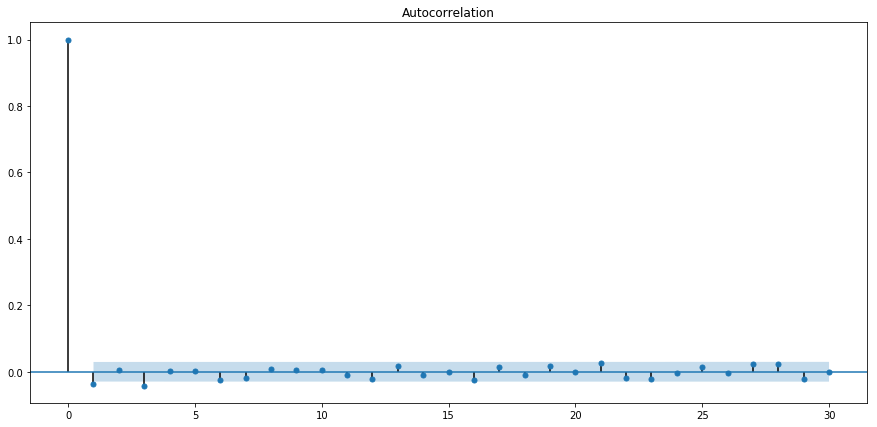

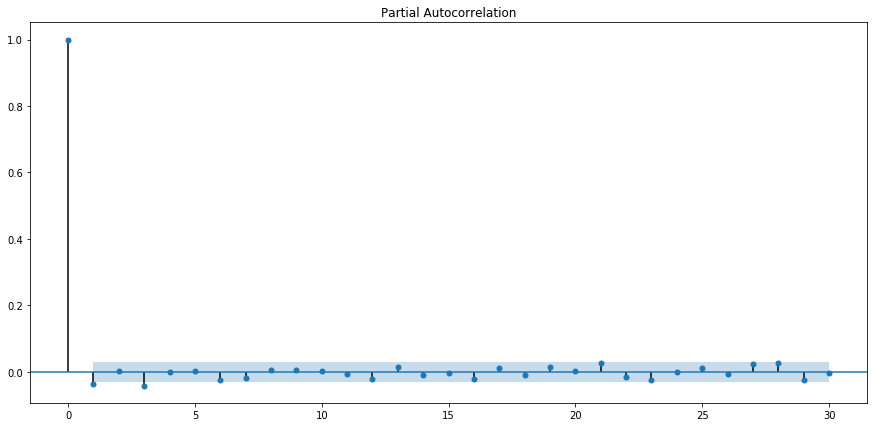

In [0]:
# ACF plot of the first order differenced data
smt.graphics.tsa.plot_acf(daily_ts_diff, lags = 30, alpha = 0.05)
plt.show()

# PACF plot of the first order differenced data
smt.graphics.tsa.plot_pacf(daily_ts_diff, lags = 30, alpha = 0.05)
plt.show()

### Manually fitting ARIMA model

After applying log transformation and first order differencing, we can see that the ACF cuts off fairly quickly. This means that the data can now be considered stationary.

As per the lecture slides: When both ACF and PACF die down quickly, check the orders at which ACF or PACF die down. The order of ACF will be the lag q of the ARIMA and the order of PACF will be the lag p of the ARIMA, and the order of difference will be d.

In this case: ACF order = 0, PACF order = 0, d = 1

In [0]:
# ARIMA(0,1,0) model
model_ARIMA = ARIMA(training_subset_log, order = (0, 1, 0))  

# Fitting the data
fit_ARIMA = model_ARIMA.fit(disp = -1)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


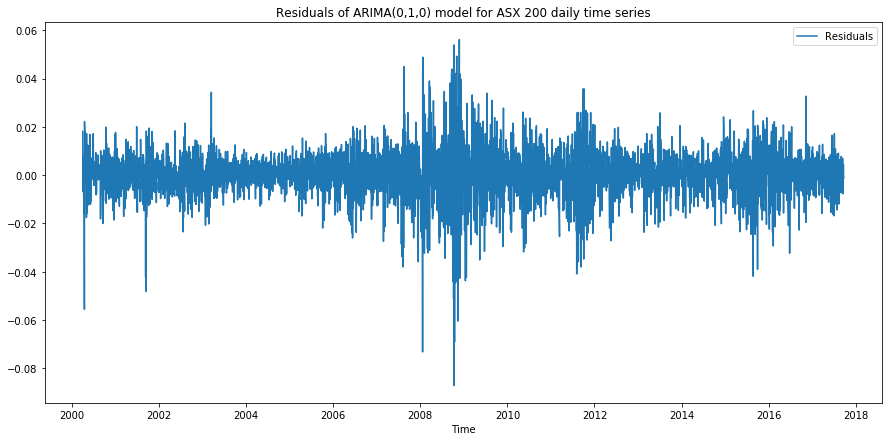

In [0]:
# Checking the residuals
residuals_ARIMA = pd.DataFrame(fit_ARIMA.resid)

plt.plot(residuals_ARIMA, label = "Residuals")
plt.xlabel('Time')
plt.title('Residuals of ARIMA(0,1,0) model for ASX 200 daily time series')
plt.legend()

In [0]:
# Forecasting 'Close' price for next 365 days (validation subset)
results_ARIMA = fit_ARIMA.predict(end=training_subset_log.size+364, typ='levels', dynamic=False)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [0]:
# Returning data to its original form by taking inverse of log
predictions_ARIMA = np.exp(results_ARIMA)

In [0]:
# Converting results into a time series
predictions_ARIMA.index = daily_ts.index[1:]

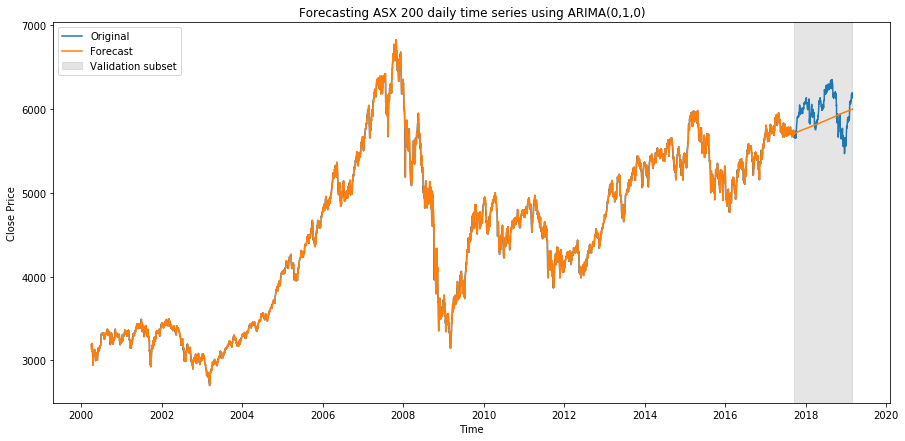

In [0]:
# Plot of Actual vs Forecasted data
plt.plot(daily_ts[1:], label="Original")
plt.plot(predictions_ARIMA, label = "Forecast")
plt.axvspan(validation_subset.index[0], validation_subset.index[validation_subset.size-1], color='grey', alpha=0.2, label="Validation subset")
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('Forecasting ASX 200 daily time series using ARIMA(0,1,0)')
plt.legend()

In [0]:
# Measuring errors of training subset
RMSE = np.sqrt(mean_squared_error(training_subset[1:], predictions_ARIMA[:-365]))
MAE = mean_absolute_error(training_subset[1:], predictions_ARIMA[:-365])
MAPE = np.mean(np.abs((training_subset[1:] - predictions_ARIMA[:-365]) / training_subset[1:])) * 100

print('Training subset ->')
print('Root Mean Squared Error (RMSE):', RMSE)
print('Mean Absolute Error (MAE):', MAE)
print('Mean Absolute Percentage Error (MAPE):', MAPE)

Training subset ->
Root Mean Squared Error (RMSE): 46.35389923983321
Mean Absolute Error (MAE): 32.15549753671014
Mean Absolute Percentage Error (MAPE): 0.7035303973724073


In [0]:
# Measuring errors of validation subset
RMSE = np.sqrt(mean_squared_error(validation_subset, predictions_ARIMA[-365:]))
MAE = mean_absolute_error(validation_subset, predictions_ARIMA[-365:])
MAPE = np.mean(np.abs((validation_subset - predictions_ARIMA[-365:]) / validation_subset)) * 100

print('Validation subset ->')
print('Root Mean Squared Error (RMSE):', RMSE)
print('Mean Absolute Error (MAE):', MAE)
print('Mean Absolute Percentage Error (MAPE):', MAPE)

Validation subset ->
Root Mean Squared Error (RMSE): 245.2187904920684
Mean Absolute Error (MAE): 214.7847214859104
Mean Absolute Percentage Error (MAPE): 3.5669293847634274


### Auto-ARIMA model

In [28]:
# Using auto-ARIMA to tune hyperparameters
autoARIMA_model = auto_arima(training_subset_log, start_p=0, start_q=0, m=5,
                          start_P=0, start_Q=0, seasonal=True, d=1, trace=True,
                          error_action='ignore',
                          suppress_warnings=True,
                          stepwise=True)

autoARIMA_model.summary()

NameError: ignored

The best model chosen by auto-ARIMA is ARIMA(1,1,0)

In [0]:
# ARIMA(1,1,0) model
train_model = autoARIMA_model.fit(training_subset_log)

In [0]:
# Calculating fitted values
fitted_values = training_subset_log + train_model.resid()

In [0]:
# Forecasting 'Close' price for next 365 days (validation subset)
results_autoARIMA = train_model.predict(n_periods=365)

In [0]:
# Converting results into a time series
results_autoARIMA = pd.Series(results_autoARIMA, index=daily_ts.index[-365:])

In [0]:
# Appending fitted values with the predicted values
predictions_autoARIMA = fitted_values.append(results_autoARIMA)

In [0]:
# Returning data to its original form by taking inverse of log
predictions_autoARIMA = np.exp(predictions_autoARIMA)

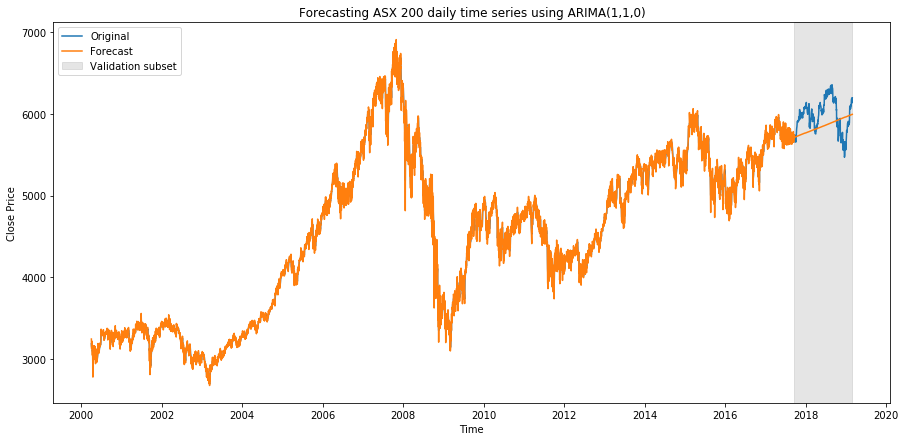

In [0]:
predictions_autoARIMA = predictions_autoARIMA[1:]

# Plot of Actual vs Forecasted data
plt.plot(daily_ts[1:], label="Original")
plt.plot(predictions_autoARIMA, label = "Forecast")
plt.axvspan(validation_subset.index[0], validation_subset.index[validation_subset.size-1], color='grey', alpha=0.2, label="Validation subset")
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('Forecasting ASX 200 daily time series using ARIMA(1,1,0)')
plt.legend()

In [0]:
# Measuring errors of training subset
RMSE = np.sqrt(mean_squared_error(training_subset[1:], predictions_autoARIMA[:-365]))
MAE = mean_absolute_error(training_subset[1:], predictions_autoARIMA[:-365])
MAPE = np.mean(np.abs((training_subset[1:] - predictions_autoARIMA[:-365]) / training_subset[1:])) * 100

print('Training subset ->')
print('Root Mean Squared Error (RMSE):', RMSE)
print('Mean Absolute Error (MAE):', MAE)
print('Mean Absolute Percentage Error (MAPE):', MAPE)

Training subset ->
Root Mean Squared Error (RMSE): 46.14374143306941
Mean Absolute Error (MAE): 32.11221277668698
Mean Absolute Percentage Error (MAPE): 0.7024975276411575


In [0]:
# Measuring errors of validation subset
RMSE = np.sqrt(mean_squared_error(validation_subset, predictions_autoARIMA[-365:]))
MAE = mean_absolute_error(validation_subset, predictions_autoARIMA[-365:])
MAPE = np.mean(np.abs((validation_subset - predictions_autoARIMA[-365:]) / validation_subset)) * 100

print('Validation subset ->')
print('Root Mean Squared Error (RMSE):', RMSE)
print('Mean Absolute Error (MAE):', MAE)
print('Mean Absolute Percentage Error (MAPE):', MAPE)

Validation subset ->
Root Mean Squared Error (RMSE): 246.4833567465957
Mean Absolute Error (MAE): 215.82047639984873
Mean Absolute Percentage Error (MAPE): 3.5822899285700185
